In [72]:
from zstandard.backend_c import frame_content_size
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [74]:
df=pd.read_csv('real_time.csv')
df=df.copy()


In [75]:
df.columns

Index(['timestamp', 'block_height', 'tx_count', 'mempool_size_mb',
       'min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate',
       'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_time',
       'difficulty', 'hash_rate', 'mempool_min_fee', 'total_fee',
       'mempool_usage', 'transaction_count', 'block_weight', 'block_version',
       'block_interval', 'block_median_fee_rate', 'time_since_last_block',
       'mempool_fee_histogram', 'bitcoin_price_usd'],
      dtype='object')

In [76]:
df.shape

(11811, 25)

In [77]:
# Convert 'block_time' to datetime
df['block_time'] = pd.to_datetime(df['block_time'], unit='s')

# Set 'block_time' as index
df.set_index('block_time', inplace=True)

In [78]:
df

,timestamp,block_height,tx_count,mempool_size_mb,min_fee_rate,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,...,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate,time_since_last_block,mempool_fee_histogram,bitcoin_price_usd
block_time,,,,,,,,,,,,,,,,,,,,,
2024-09-16 06:44:46,1726469858,861523,59716,51.681340,1.0,403.4234,1.8891,2.0068,1.0166,2.0794,...,82339680.0,292674144,4407,3993295,689364992,NaN,2.1032,NaN,"[59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]",58657.0
2024-09-16 07:01:15,1726470091,861524,57979,50.830730,1.0,14.2340,1.7086,2.0039,1.0160,2.0714,...,77637217.0,288180656,2292,3993188,838860800,989.0,4.0000,989.0,"[57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]",58657.0
2024-09-16 07:05:01,1726470324,861525,53178,50.142707,1.0,25.1185,1.6743,2.0000,1.0157,2.0714,...,76177612.0,282014400,5760,3993640,551452672,226.0,2.0794,226.0,"[53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]",58701.0
2024-09-16 07:34:53,1726472117,861526,58865,51.178547,1.0,300.0000,1.7449,2.0068,1.0160,2.0794,...,78821229.0,290099120,3404,3993080,620822528,1792.0,4.8216,1792.0,"[58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]",58863.0
2024-09-16 07:35:35,1726472180,861527,53746,50.270880,1.0,70.0000,1.6885,2.0000,1.0157,2.0714,...,76581819.0,283002176,5329,3992931,827326464,42.0,2.0952,42.0,"[53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]",58863.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-15 16:12:16,1734279152,874885,51627,43.578104,1.0,387.0818,1.6602,1.2026,1.0088,2.8129,...,74100207.0,227707728,1360,3993664,547356672,334.0,6.0000,334.0,"[51616, 1, 1, 0, 3, 0, 0, 5, 0, 1]",102673.0
2024-12-15 16:27:20,1734280055,874886,51924,44.043686,1.0,387.0818,1.6667,1.2047,1.0088,2.9459,...,76143037.0,228755008,3532,3993525,771751936,904.0,6.5847,904.0,"[51910, 4, 1, 0, 3, 0, 0, 5, 0, 1]",103089.0
2024-12-15 16:32:46,1734280378,874887,52034,43.689318,1.0,387.0818,1.6645,1.2047,1.0089,3.0000,...,74289229.0,228455648,1451,3993505,672776192,326.0,6.0000,326.0,"[52023, 2, 0, 0, 3, 0, 0, 5, 0, 1]",103139.0


In [79]:
print("Original data_history shape:", df.shape)

Original data_history shape: (11811, 24)


In [80]:
import pandas as pd
import numpy as np

def extract_histogram_features(histogram):
    try:
        # Handle different input types
        if isinstance(histogram, str):
            histogram = eval(histogram)
        elif isinstance(histogram, (int, float)):
            return {
                'hist_low_fee_ratio': 0,
                'hist_med_fee_ratio': 0,
                'hist_high_fee_ratio': 0,
                'hist_fee_diversity': 0
            }
            
        # Ensure histogram is a list with at least 10 elements
        if len(histogram) < 10:
            histogram = histogram + [0] * (10 - len(histogram))
            
        total_txs = sum(histogram)
        if total_txs == 0:
            return {
                'hist_low_fee_ratio': 0,
                'hist_med_fee_ratio': 0,
                'hist_high_fee_ratio': 0,
                'hist_fee_diversity': 0
            }
        
        low_fee_ratio = histogram[0] / total_txs
        med_fee_ratio = sum(histogram[1:5]) / total_txs  # Bins 2-5
        high_fee_ratio = sum(histogram[5:]) / total_txs  # Bins 6-10
        
        # Calculate fee diversity with protection against single-element histograms
        if len(histogram) == 1:
            fee_diversity = 0
        else:
            non_zero_bins = sum(1 for count in histogram if count > 0)
            fee_diversity = (non_zero_bins - 1) / (len(histogram) - 1)  # Normalized to [0, 1]
        
        return {
            'hist_low_fee_ratio': low_fee_ratio,
            'hist_med_fee_ratio': med_fee_ratio,
            'hist_high_fee_ratio': high_fee_ratio,
            'hist_fee_diversity': fee_diversity
        }
    except Exception as e:
        print(f"Error processing histogram: {histogram}")
        print(f"Error details: {str(e)}")
        return {
            'hist_low_fee_ratio': 0,
            'hist_med_fee_ratio': 0,
            'hist_high_fee_ratio': 0,
            'hist_fee_diversity': 0
        }

new features mean:

hist_low_fee_ratio: Proportion of transactions in the lowest fee bin (first bin).

hist_med_fee_ratio: Proportion of transactions in the medium fee range (bins 2-5).

hist_high_fee_ratio: Proportion of transactions in the high fee range (bins 6-10).

hist_fee_diversity: A measure of how spread out the transactions are across different fee bins.

0 means all transactions are in one bin

1 means transactions are evenly spread across all bins

These features provide insights into:

The overall distribution of transaction fees

Whether most transactions are paying low, medium, or high fees

How diverse the fee landscape is at any given time

In [81]:
# Apply the function and create new columns
df['histogram_features'] = df['mempool_fee_histogram'].apply(extract_histogram_features)

# Split the dictionary into separate columns
df['hist_low_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_low_fee_ratio'])
df['hist_med_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_med_fee_ratio'])
df['hist_high_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_high_fee_ratio'])
df['hist_fee_diversity'] = df['histogram_features'].apply(lambda x: x['hist_fee_diversity'])

# Clean up by dropping the intermediate dictionary column
df.drop('histogram_features', axis=1, inplace=True)

# Display the results with some basic statistics
print("\nSample of processed data:")
print(df[['mempool_fee_histogram', 'hist_low_fee_ratio', 'hist_med_fee_ratio', 
          'hist_high_fee_ratio', 'hist_fee_diversity']].head())

print("\nSummary statistics:")
print(df[['hist_low_fee_ratio', 'hist_med_fee_ratio', 
          'hist_high_fee_ratio', 'hist_fee_diversity']].describe())


Sample of processed data:
                                     mempool_fee_histogram  \
block_time                                                   
2024-09-16 06:44:46    [59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]   
2024-09-16 07:01:15  [57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]   
2024-09-16 07:05:01    [53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]   
2024-09-16 07:34:53     [58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]   
2024-09-16 07:35:35    [53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]   

                     hist_low_fee_ratio  hist_med_fee_ratio  \
block_time                                                    
2024-09-16 06:44:46            0.999581            0.000335   
2024-09-16 07:01:15            0.994032            0.005881   
2024-09-16 07:05:01            0.999210            0.000715   
2024-09-16 07:34:53            0.999983            0.000000   
2024-09-16 07:35:35            0.999460            0.000502   

                     hist_high_fee_ratio  hist_fee_diversity  
block_time                       

In [82]:
def plot_boxplots(df, title):
    n_cols = len(df.columns)
    n_rows = (n_cols) // 4  
    
    plt.figure(figsize=(20, 5 * n_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[column])
        plt.title(column)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [83]:
duplicates = df.duplicated().sum()


In [84]:
duplicates

2

In [85]:
nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)


Columns with NaN values:
block_interval             7
block_median_fee_rate     34
time_since_last_block      7
mempool_fee_histogram    220
bitcoin_price_usd         44
dtype: int64


In [86]:
columns_with_nan.index

Index(['block_interval', 'block_median_fee_rate', 'time_since_last_block',
       'mempool_fee_histogram', 'bitcoin_price_usd'],
      dtype='object')

Original data_history shape: (11811, 28)
Removed 2 duplicate rows.

Columns with NaN values:
block_interval             7
block_median_fee_rate     34
time_since_last_block      7
mempool_fee_histogram    220
bitcoin_price_usd         44
dtype: int64
No NaN values found after handling.


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_17263/3532653052.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_17263/3532653052.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].ffill().bfill()
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_17263/3532653052.py:28: SettingWithCopyWarning: 
A value is trying to be set on

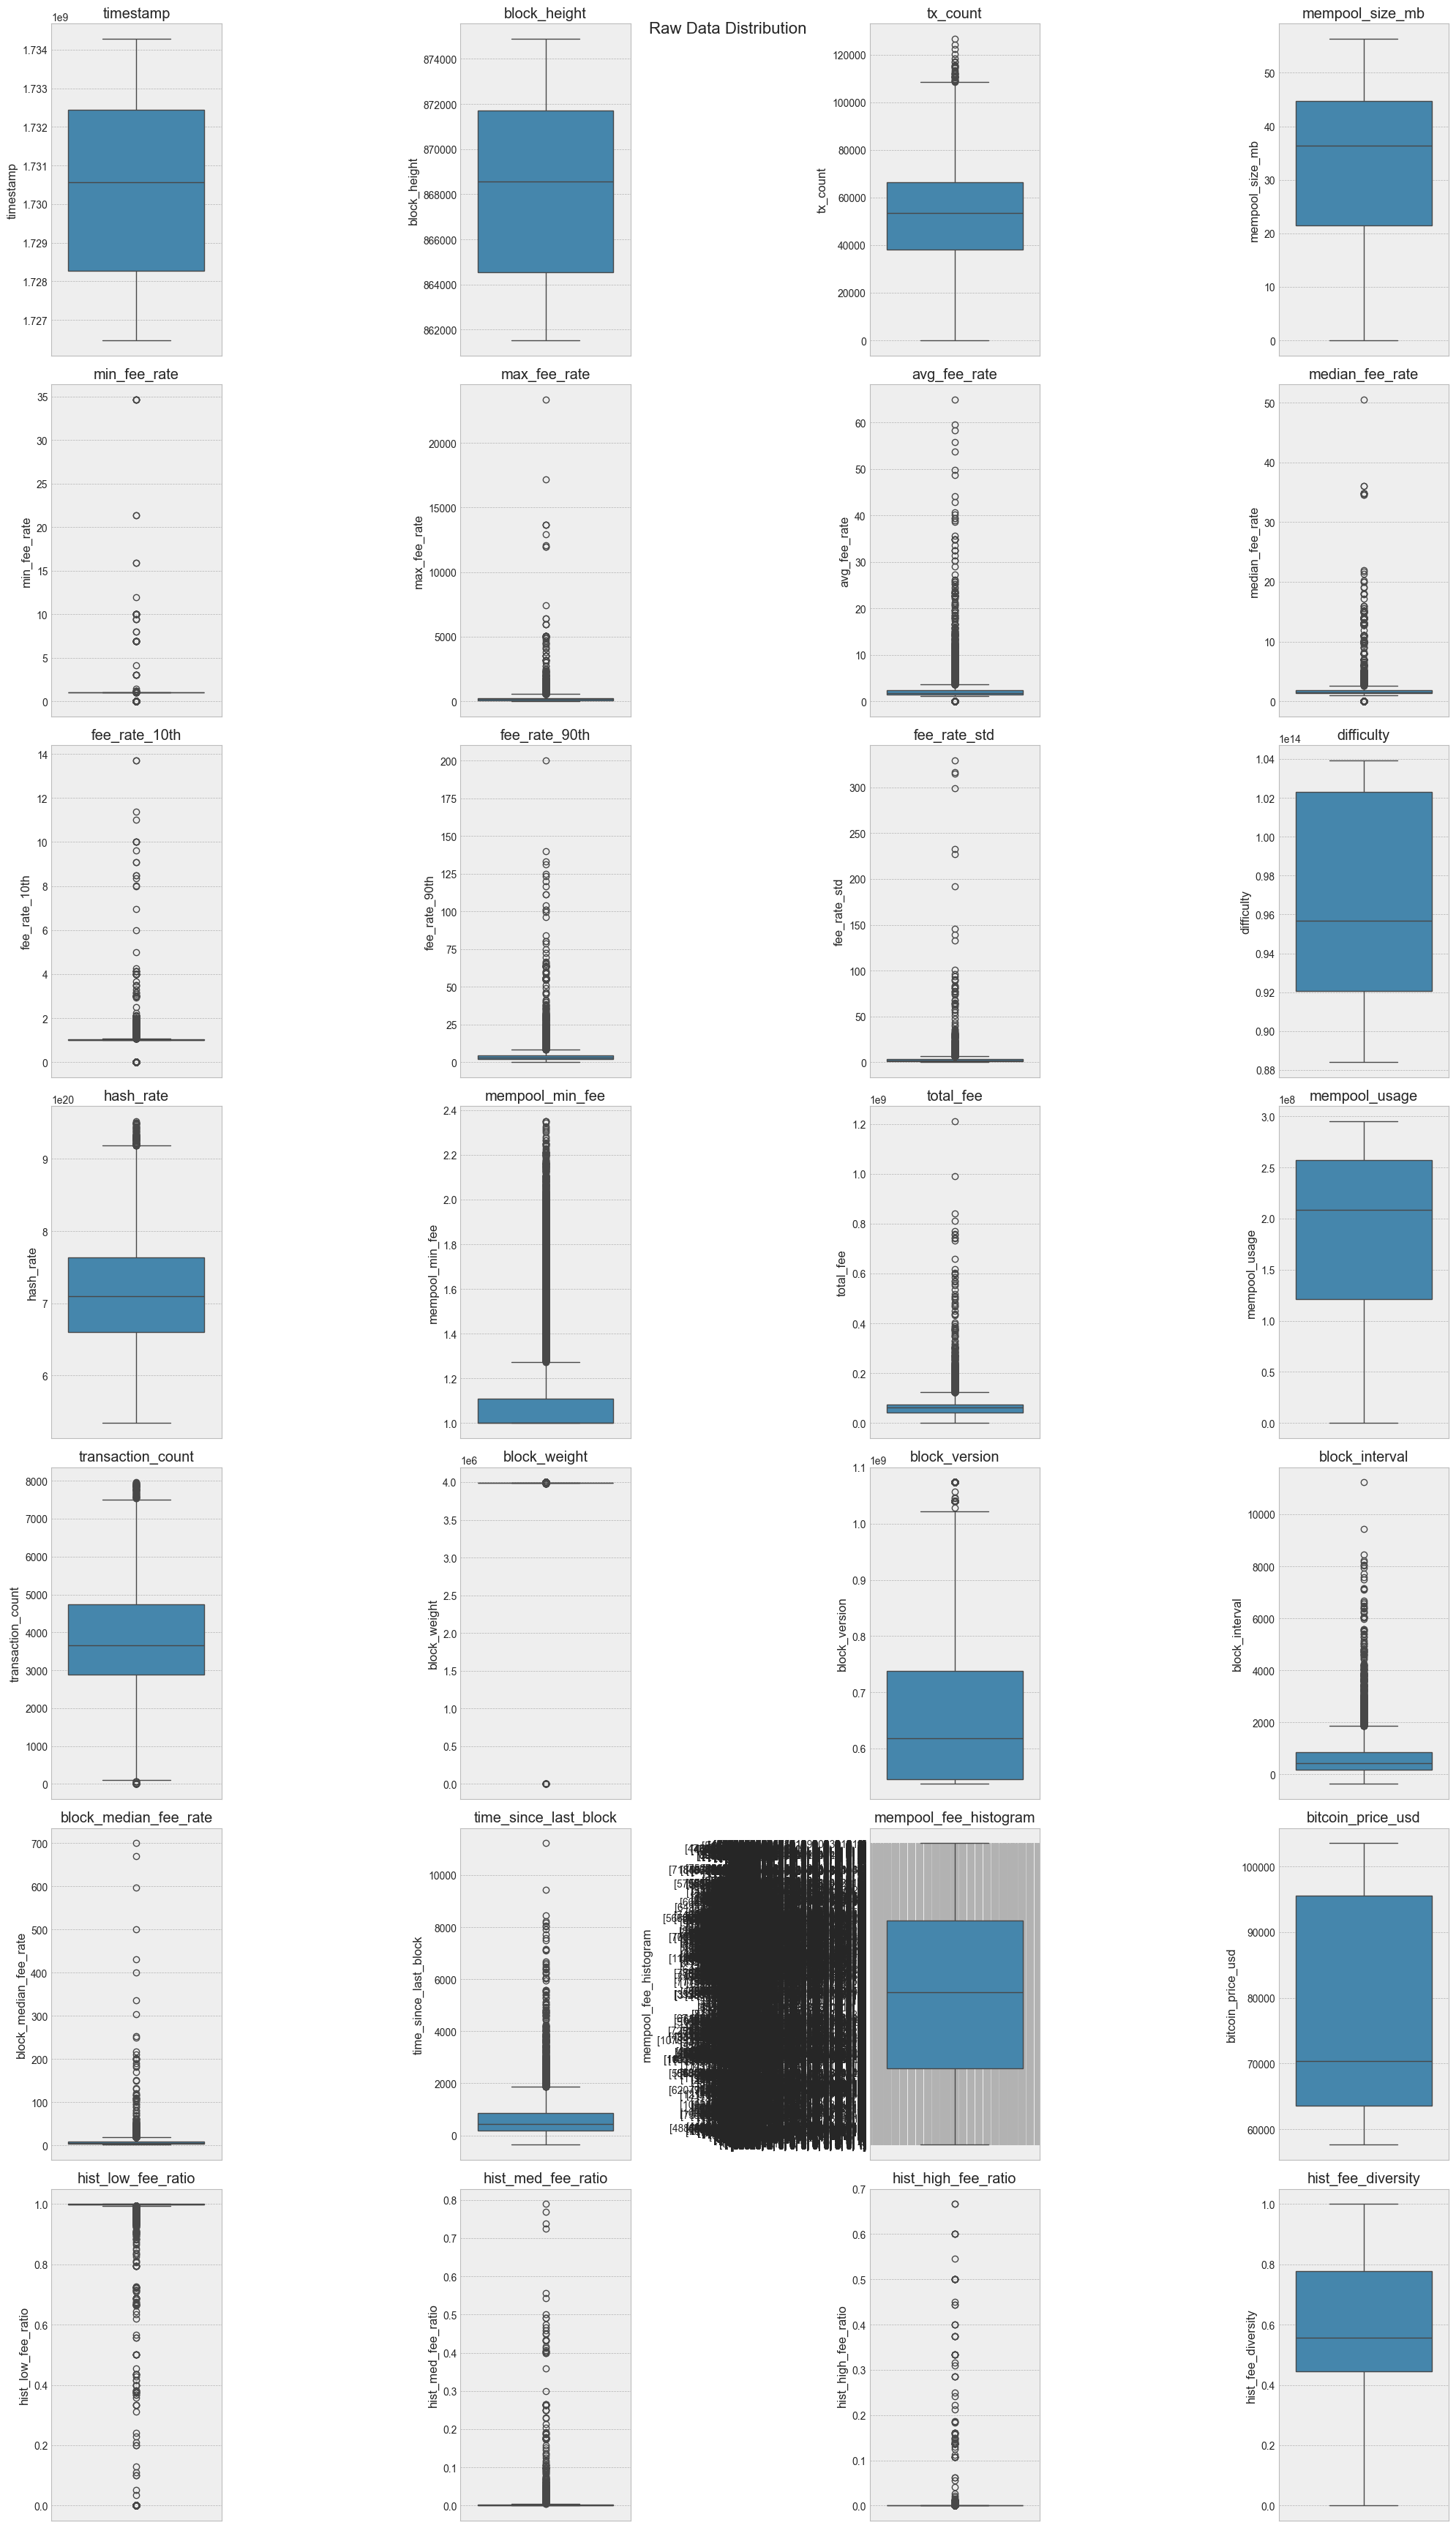

In [87]:
print("Original data_history shape:", df.shape)

duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")

nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)
    
    # Handle NaN values
    median_interval = df['block_interval'].median()  # Calculate median interval once
    for column in columns_with_nan.index:
        if column == 'block_interval':
            # For the first row, use the median interval. For others, forward fill.
            df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
        elif column == 'block_median_fee_rate':
            # Use forward fill, then backward fill for any remaining NaNs
            df[column] = df[column].ffill().bfill()
        elif column in ['mempool_size_mb', 'tx_count', 'mempool_usage']:
            # For mempool-related metrics, 0 might be appropriate if the mempool was empty
            df[column] = df[column].fillna(0)
        else:
            # For other columns, use forward fill, then backward fill
            
            df[column] = df[column].ffill().bfill()

    remaining_nans = df.isna().sum()[df.isna().sum() > 0]
    if not remaining_nans.empty:
        print("\nRemaining NaN values after handling:")
        print(remaining_nans)
    else:
        print("No NaN values found after handling.")
else:
    print("No NaN values found.")

# If there are still any NaN values, drop those rows
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
if rows_before > rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values.")


if df.empty:
    print("Warning: DataFrame is empty after cleaning. Please check the data_history processing steps.")
else:
    # Plotting the distribution of the cleaned data_history
    plot_boxplots(df, "Raw Data Distribution")


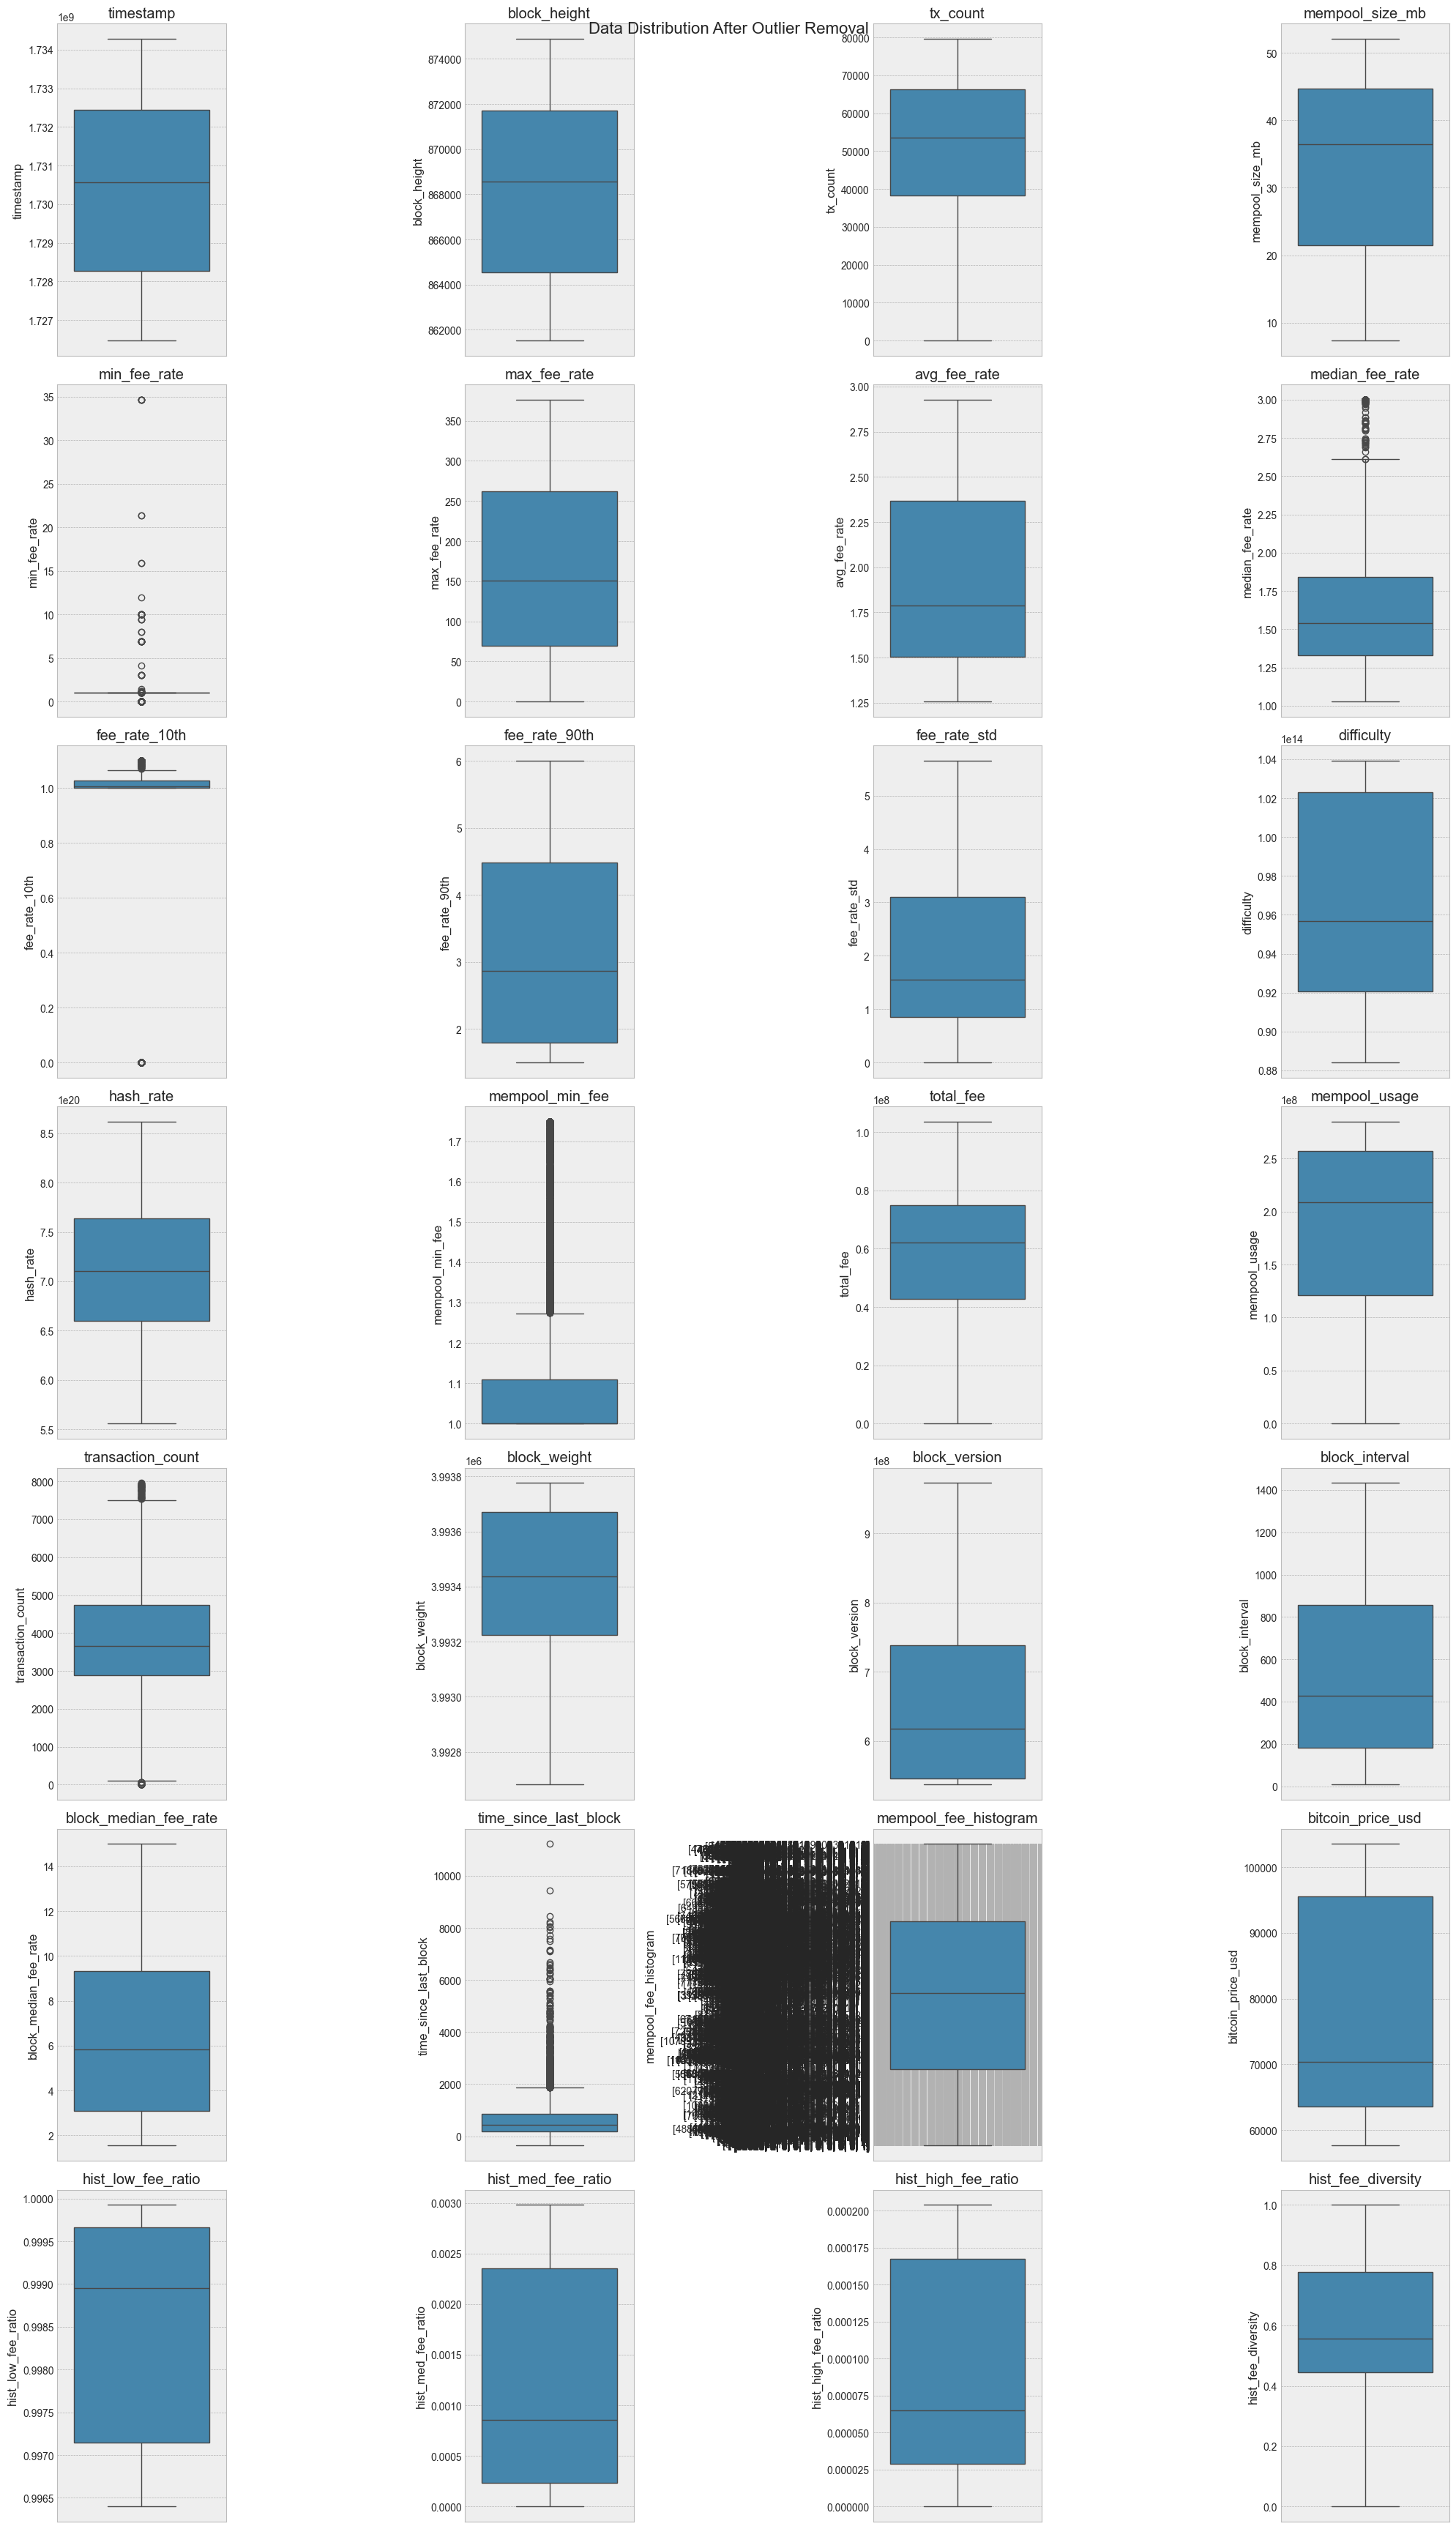

In [88]:
# Define a function to remove outliers by clipping based on percentiles
def remove_outliers(data, column, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data[column], lower_percentile)
    upper = np.percentile(data[column], upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# Use the .clip(lower, upper) method to adjust values below the lower bound to the lower bound and values above the upper bound to the upper bound.
# Define a dictionary for custom percentiles for each column
percentile_dict = {
    'fee_rate_90th': (5, 85),
    'fee_rate_10th': (1, 80),
    'difficulty': (1, 99),
    'max_fee_rate': (1, 85),
    'avg_fee_rate': (5, 85),
    'fee_rate_std': (1, 90),
    'total_fee': (1, 90),
    'block_weight': (1, 85),
    'block_interval': (1, 90),
    'block_median_fee_rate': (1, 90),
    'bitcoin_price_used': (1, 90),
   'block_version': (1, 95),
    'hist_low_fee_ratio': (20, 95),
    'hist_med_fee_ratio': (1, 80),
    'hist_high_fee_ratio': (1, 80),
    'tx_count':(1,90),
    'mempool_size_mb': (5, 99),
    'median_fee_rate':(5,95),
    'hash_rate':(1,95),
    'mempool_usage':(1,95),
    'mempool_min_fee':(1,90),
    
}

# Apply outlier handling with custom percentiles
for column in df.columns:
    if column in percentile_dict:
        lower_p, upper_p = percentile_dict[column]
        df_cleaned = remove_outliers(df, column, lower_p, upper_p)
    # elif column not in ['block_height', 'timestamp', 'mempool_fee_histogram']:
    #     df_cleaned = remove_outliers(df, column)
    



plot_boxplots(df_cleaned, "Data Distribution After Outlier Removal")

In [89]:
df_cleaned.shape

(11809, 28)

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df, features, rows=3, cols=3, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        if i < len(axes) and feature in df.columns:
            ax = axes[i]
            df.plot(y=feature, ax=ax)
            ax.set_title(feature)
            ax.set_xlabel('Time')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


block_features = ['block_height', 'timestamp', 'block_weight', 'block_version', 'block_interval', 'block_median_fee_rate', 'transaction_count']

mempool_features = ['tx_count', 'min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'mempool_min_fee', 'mempool_size_mb', 'mempool_usage', 'total_fee','hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio','hist_fee_diversity']

network_features = ['difficulty', 'hash_rate']

bitcoin_features = ['bitcoin_price_usd']



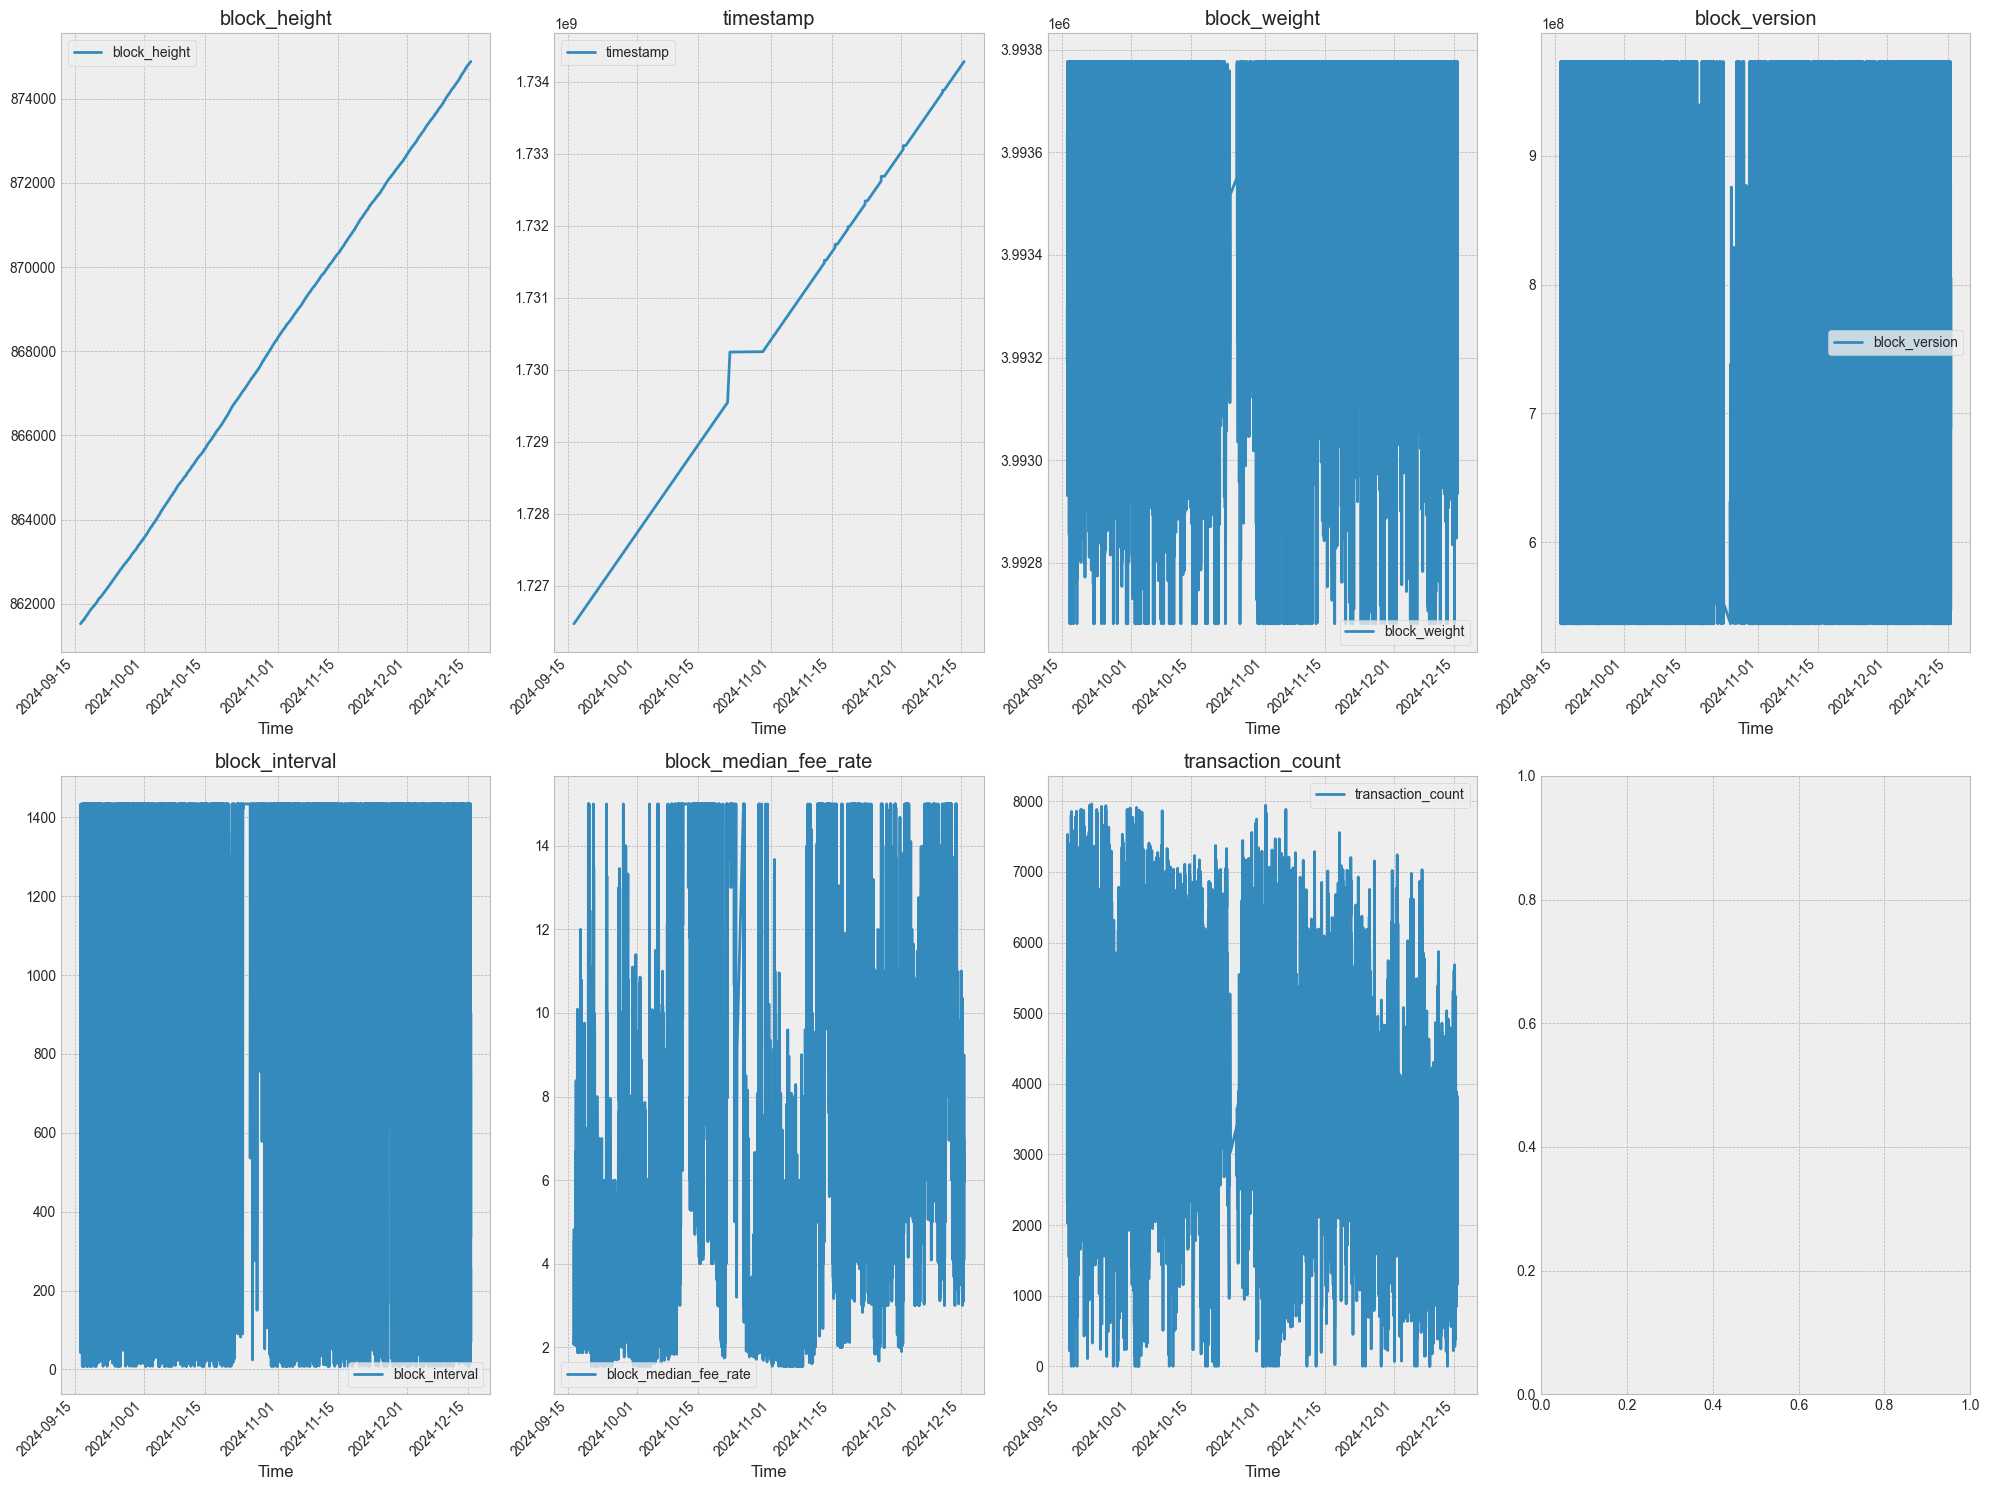

In [91]:
plot_time_series(df_cleaned, block_features,rows=2, cols=4)

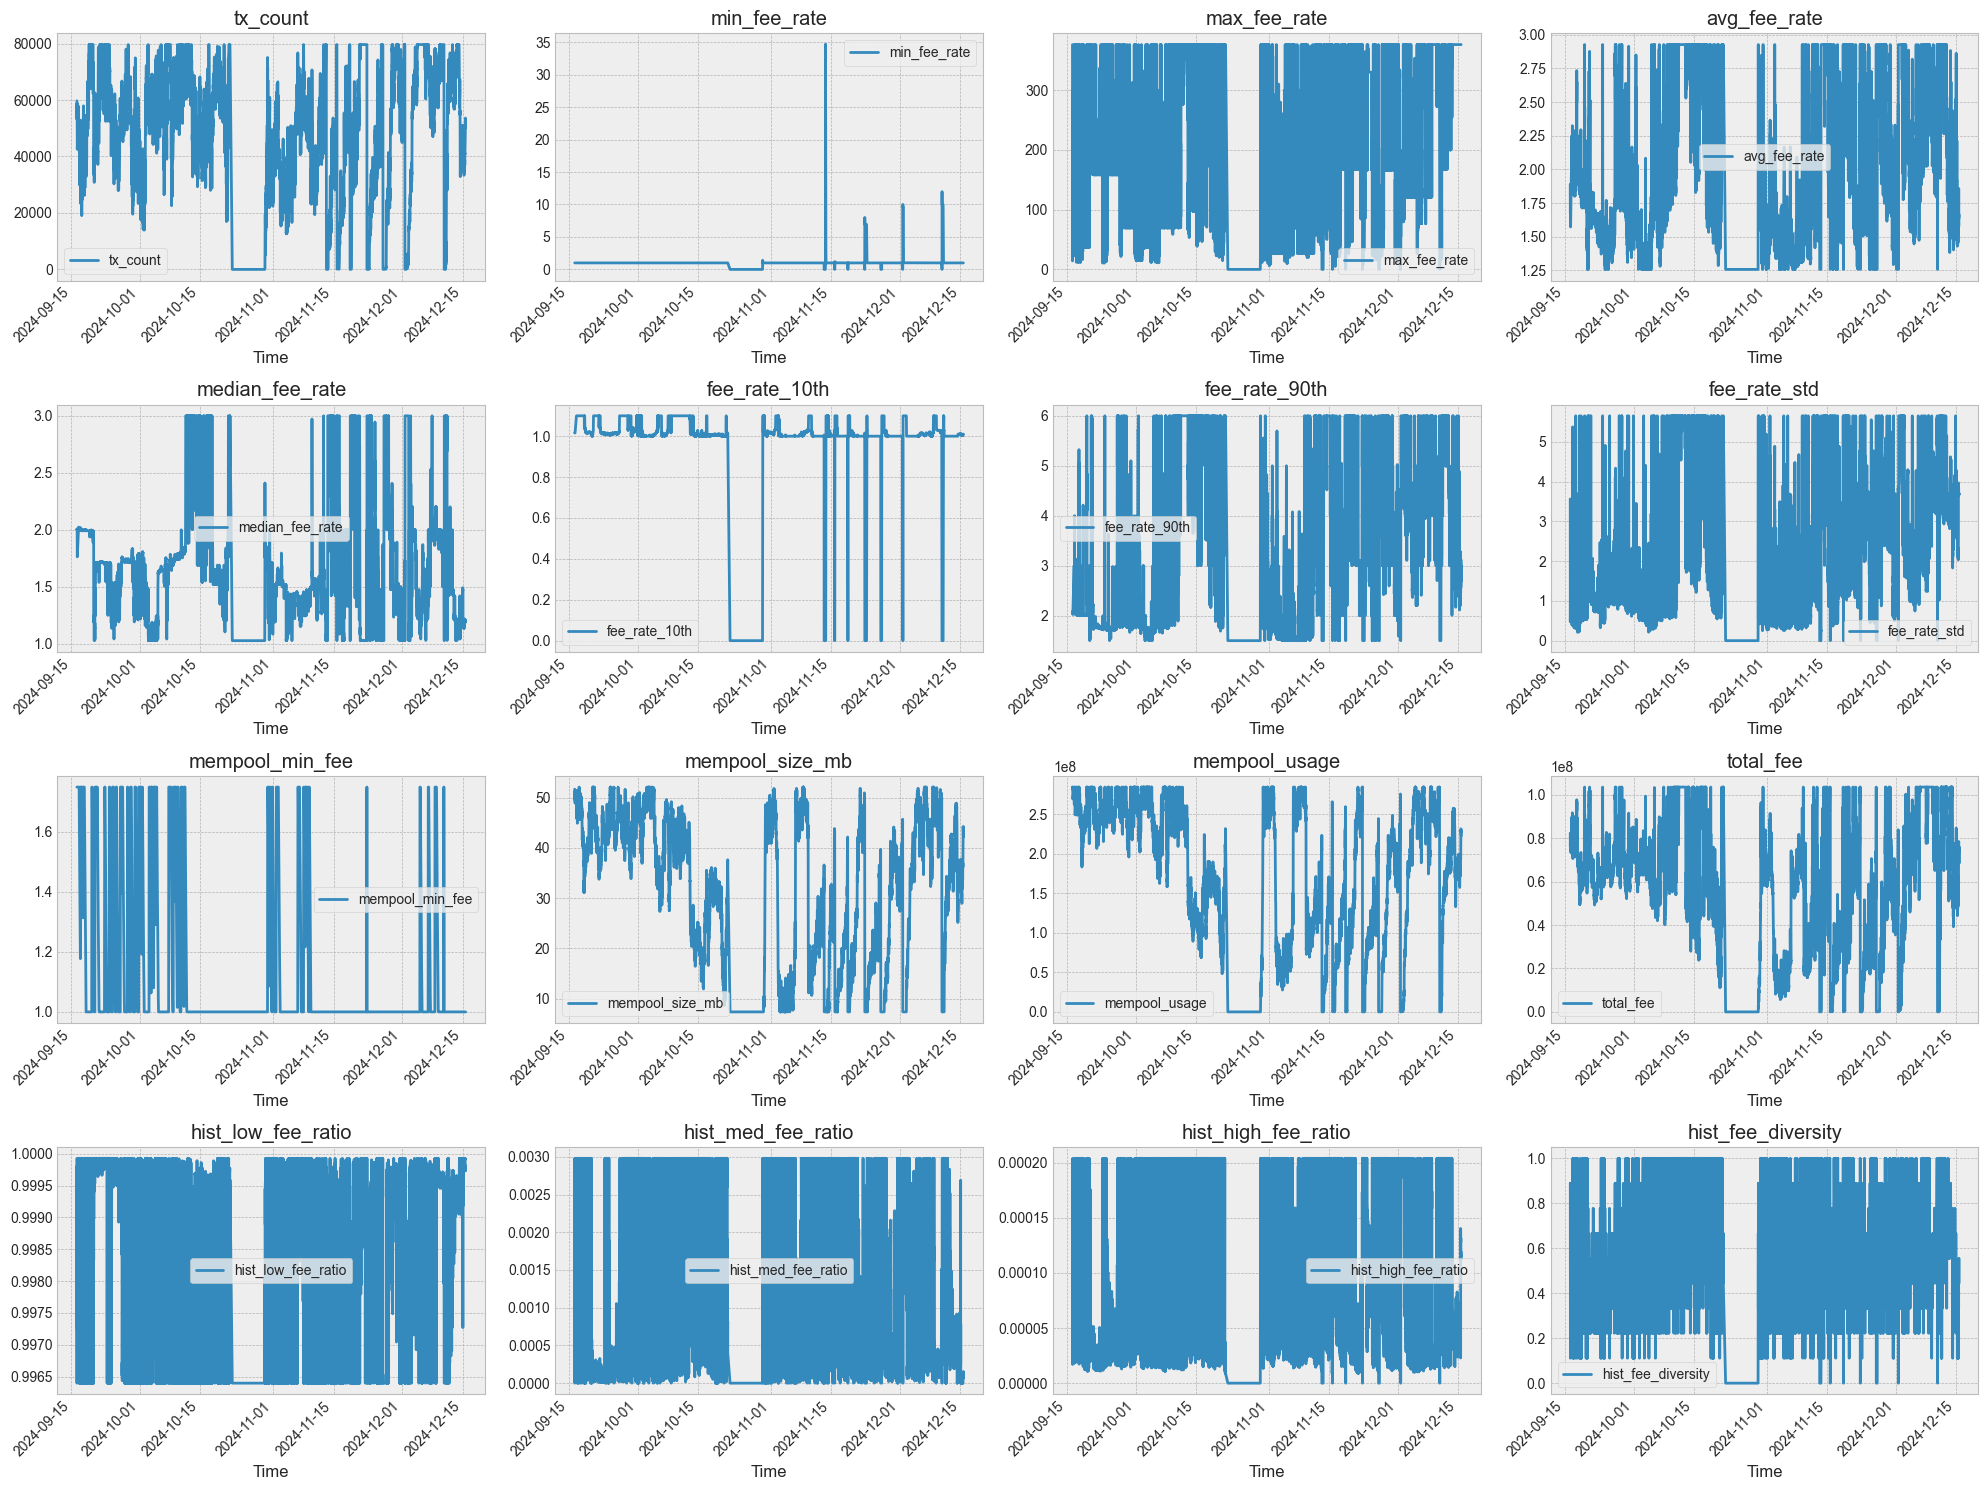

In [92]:
plot_time_series(df_cleaned, mempool_features,rows=4, cols=4)

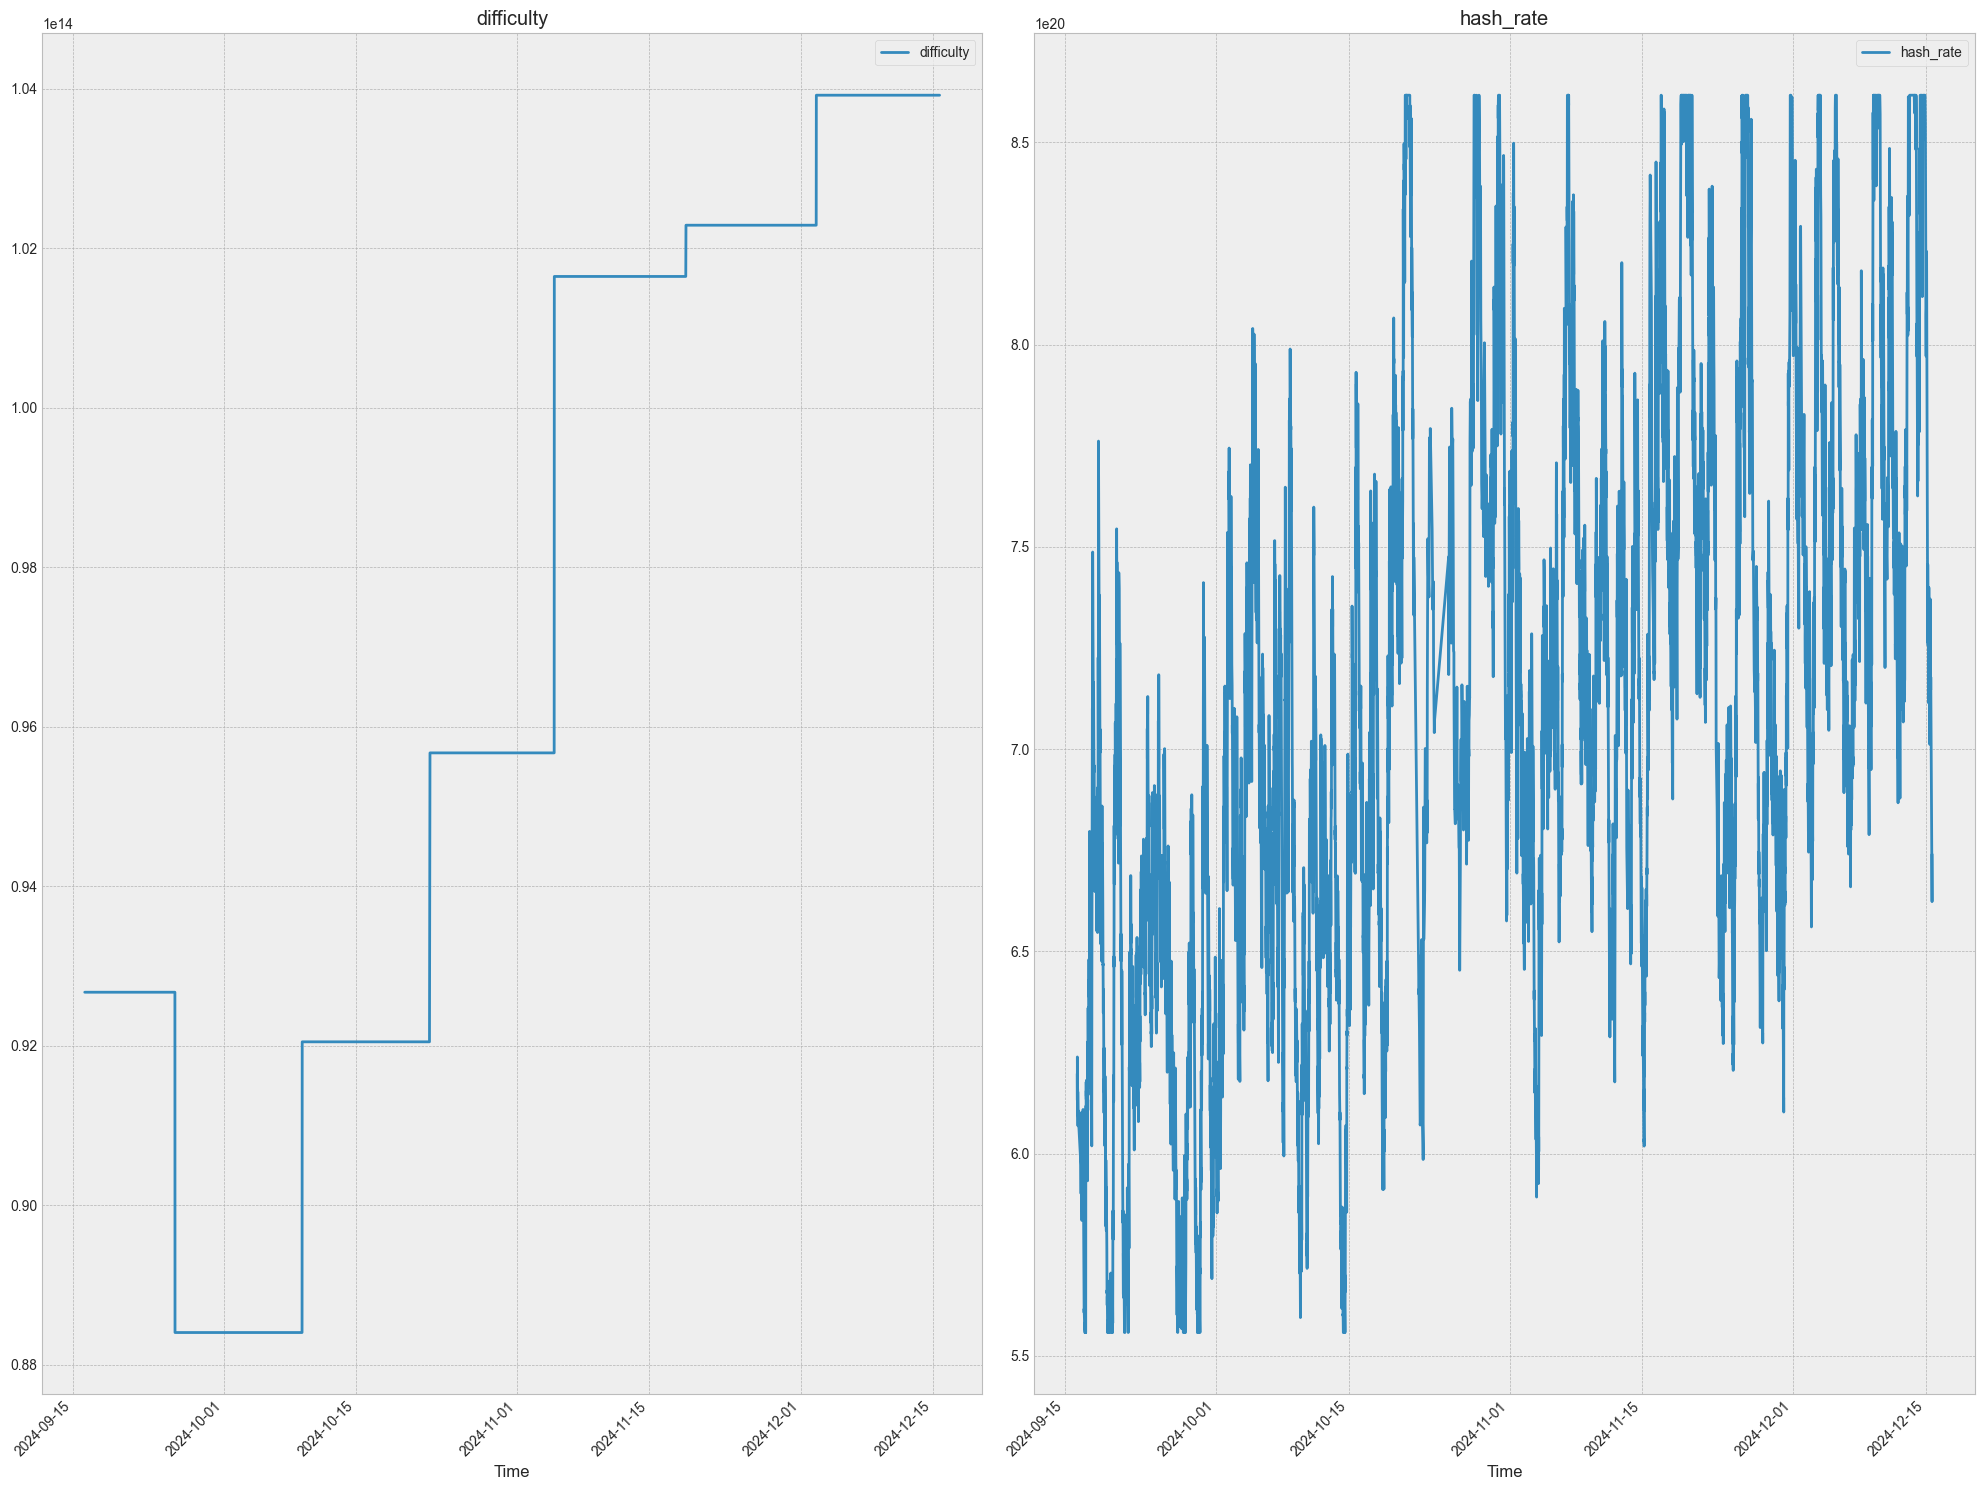

In [93]:
plot_time_series(df_cleaned, network_features,rows=1, cols=2)

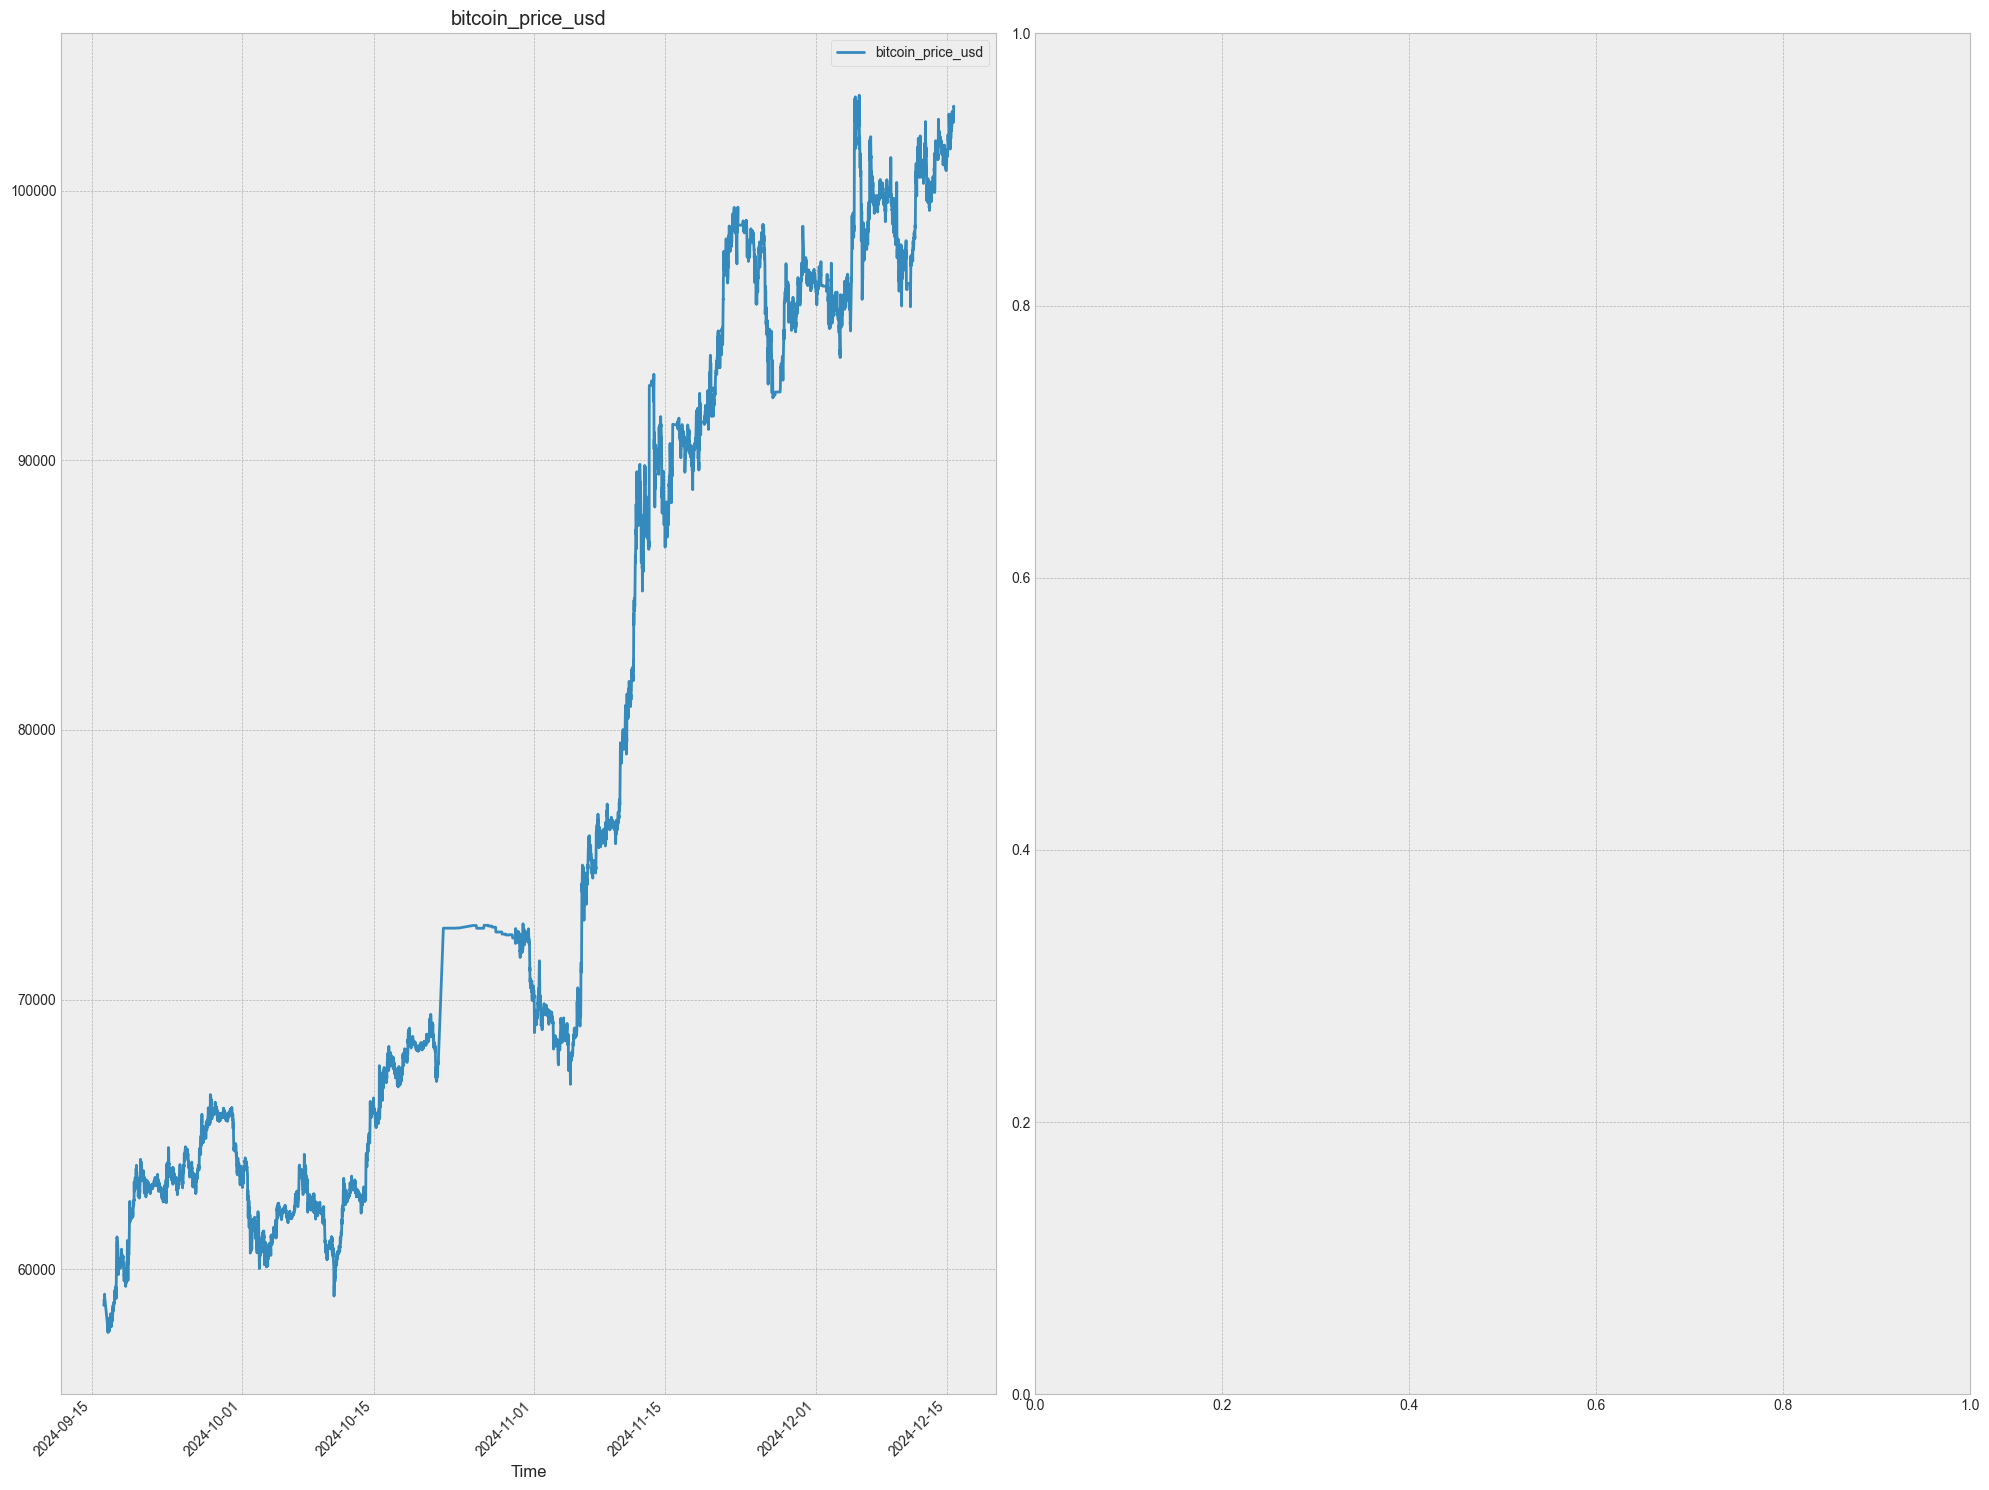

In [94]:
plot_time_series(df_cleaned, bitcoin_features,rows=1, cols=2)

In [95]:
df_cleaned.drop(columns=['time_since_last_block','timestamp','min_fee_rate'], inplace=True)

In [96]:
df_cleaned.shape

(11809, 25)

In [97]:
df_cleaned.to_csv('real_time_cleaned.csv')

In [98]:
pd.read_csv('real_time_cleaned.csv').shape

(11809, 26)

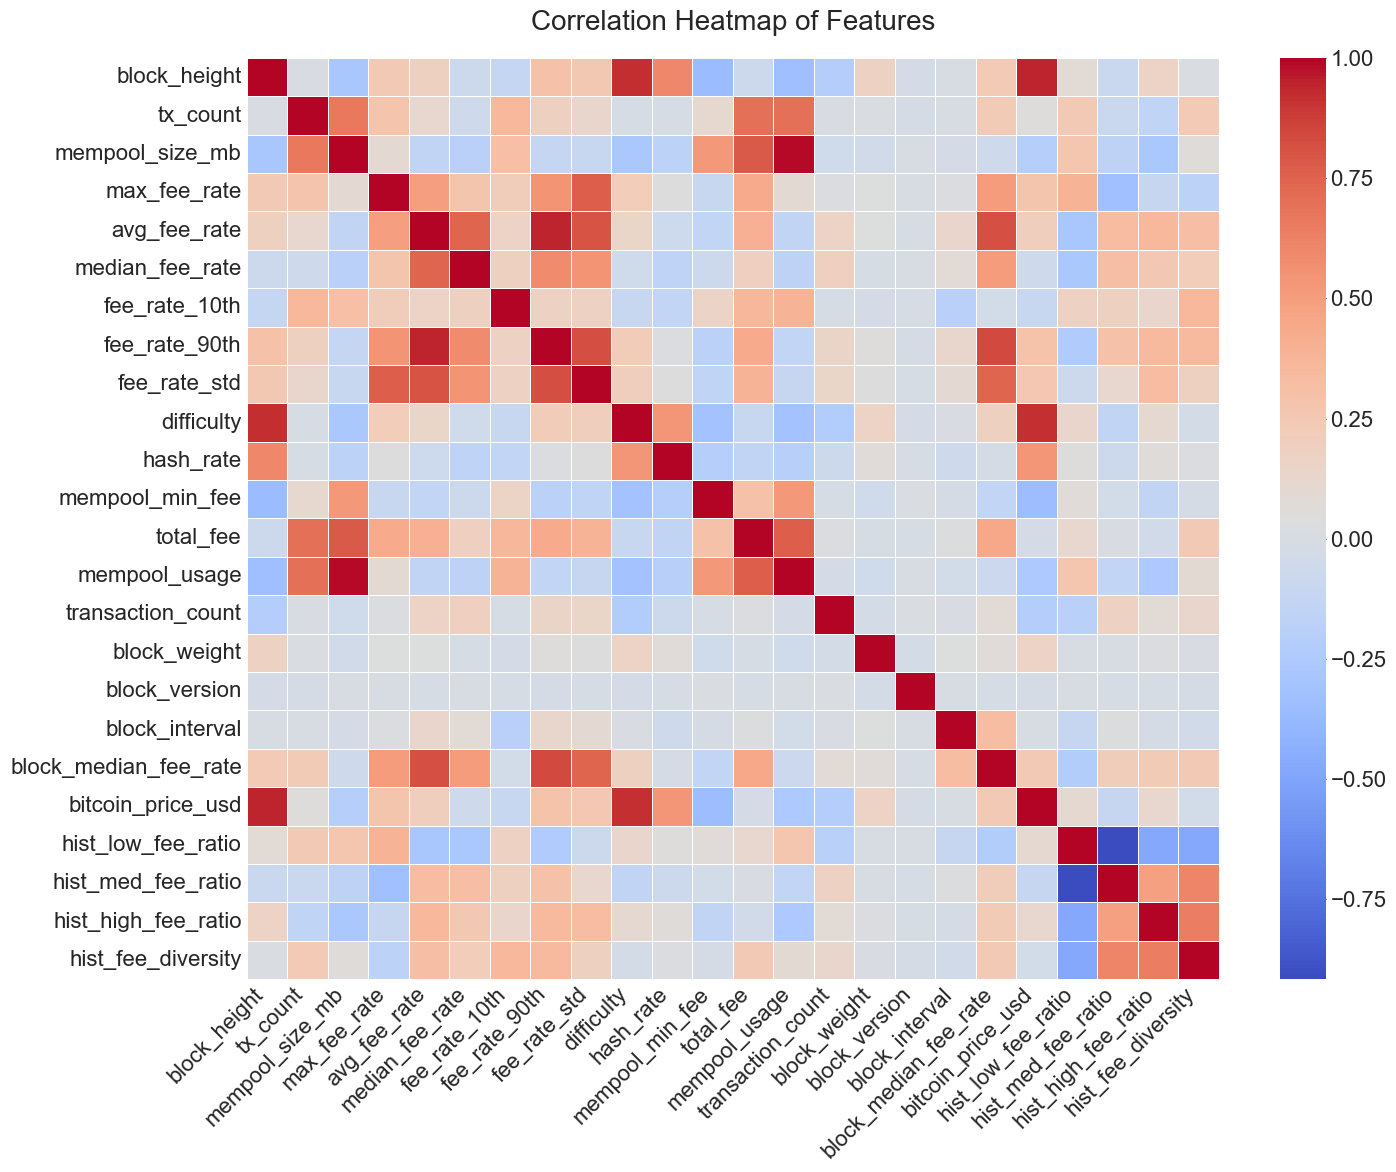

In [99]:
# Set font sizes
plt.rcParams.update({'font.size': 16})  # Set global font size

# Create correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_cleaned.drop(columns=['mempool_fee_histogram']).corr(), 
            annot=False, 
            cmap='coolwarm', 
            linewidths=0.5,
            xticklabels=True,
            yticklabels=True)

# Set title with font size 16
plt.title('Correlation Heatmap of Features', fontsize=20, pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save figure
plt.savefig('correlation_heatmap.png', bbox_inches='tight', dpi=600)
plt.show()

# Reset to default font size if needed
plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

In [100]:
key_features=['tx_count',
 'mempool_size_mb',
 'block_median_fee_rate',
'fee_rate_std']

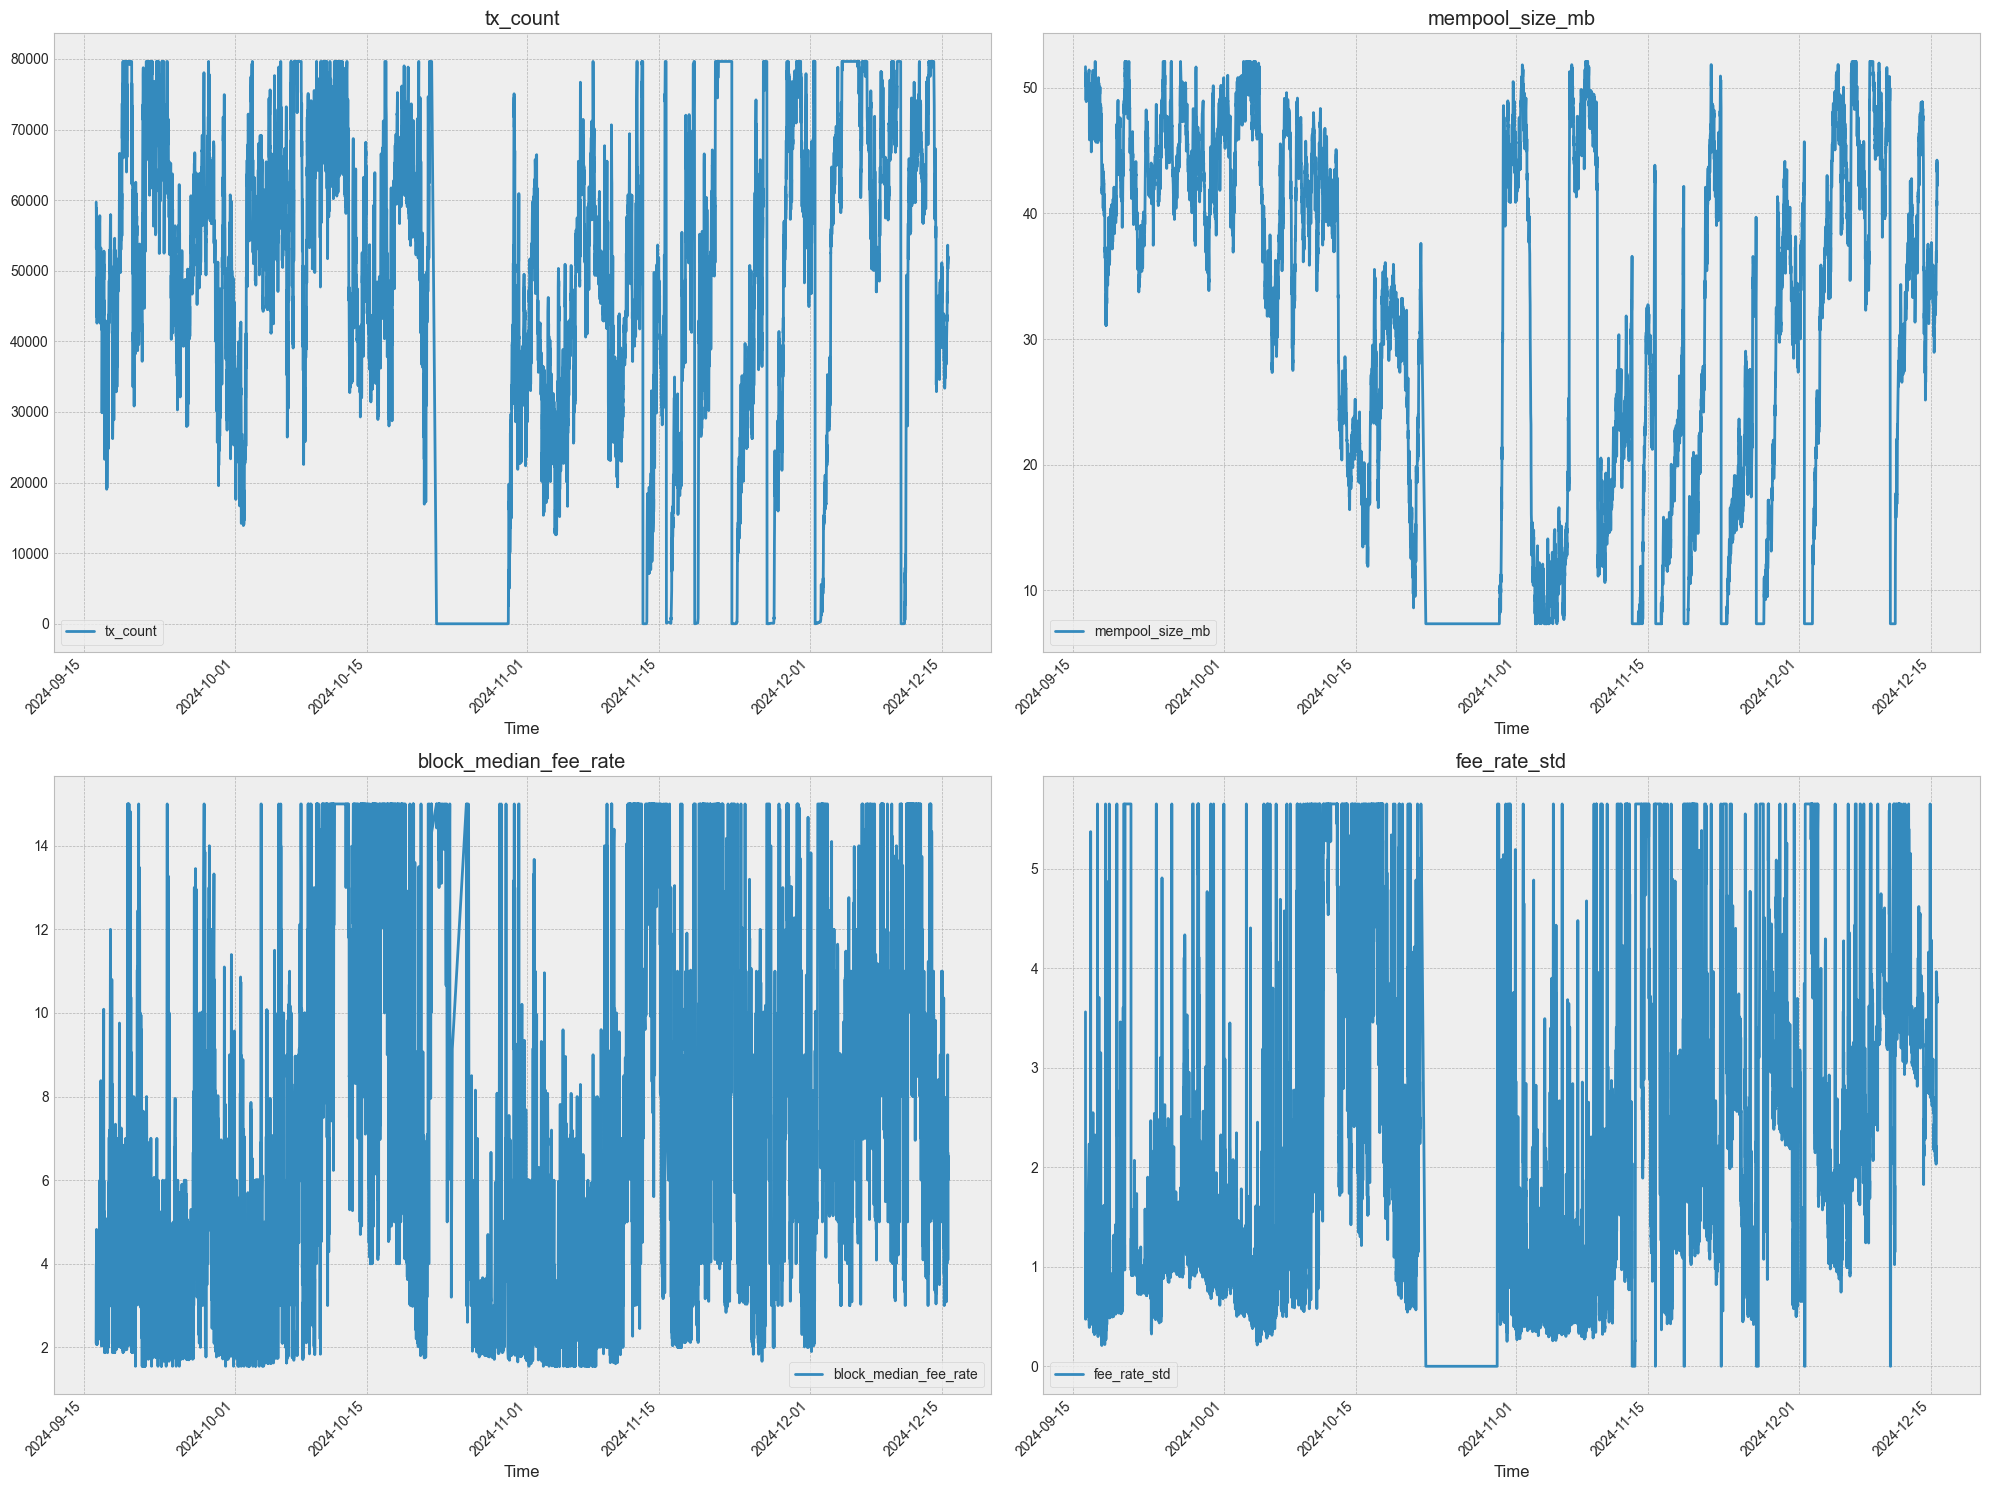

In [101]:
plot_time_series(df_cleaned, key_features,rows=2, cols=2)

In [102]:

time_range = f"Data spans from {df_cleaned.index.min().strftime('%B %d, %Y')} to {df_cleaned.index.max().strftime('%B %d, %Y')}"
print(time_range)

Data spans from September 16, 2024 to December 15, 2024


In [103]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os

def plot_key_features(df_cleaned):
    # Use a built-in style
    plt.style.use('bmh')
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    features = ['tx_count', 'mempool_size_mb', 'block_median_fee_rate', 'fee_rate_std']
    
    # Updated titles to reflect proper categorization
    titles = ['Transaction Activity', 
             'Network Congestion State', 
             'Block Median Fee Rate (Target Variable)', 
             'Fee Rate Dispersion']
    
    for idx, (feature, title) in enumerate(zip(features, titles)):
        axes[idx].plot(df_cleaned.index, df_cleaned[feature], 
                      color='#1f77b4', linewidth=1)
        axes[idx].set_title(title, fontsize=20, pad=10)
        axes[idx].set_xlabel('Time', fontsize=20)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45,labelsize=16)
        axes[idx].tick_params(axis='y', labelsize=16)
        
        # Updated y-axis labels
        if feature == 'tx_count':
            axes[idx].set_ylabel('Number of Transactions', fontsize=20)
        elif feature == 'mempool_size_mb':
            axes[idx].set_ylabel('Mempool Size (MB)', fontsize=20)
        elif feature == 'block_median_fee_rate':
            axes[idx].set_ylabel('Fee Rate', fontsize=20)
        else:
            axes[idx].set_ylabel('Standard Deviation', fontsize=20)
    
    # Updated main title to better reflect the content
    plt.suptitle(f'Bitcoin Transaction Activity, Network State, and Fee Dynamics\n({df_cleaned.index.min().strftime("%B %d, %Y")} - {df_cleaned.index.max().strftime("%B %d, %Y")})', 
                fontsize=20, y=1.02)
    
    plt.tight_layout()
    
    # Get current working directory
    current_dir = os.getcwd()
    file_path = os.path.join(current_dir, 'bitcoin_metrics.png')
    
    plt.savefig(file_path, dpi=600, bbox_inches='tight')
    plt.close()
    
    if os.path.exists(file_path):
        print(f"File saved successfully at: {file_path}")
    else:
        print("Error: File was not saved")
    
    return file_path

# Run the function
save_path = plot_key_features(df_cleaned)

File saved successfully at: /Users/jiangqinma/Documents/bitcoin/Data/Data_larger dataset/bitcoin_metrics.png


In [106]:
# Split the dataset for training and testing
# Load the dataset
file_path = 'real_time_cleaned.csv'
df = pd.read_csv(file_path)

# Split the dataset
train_df = df.iloc[:-144]  # All rows except the last 144 for training
test_df = df.iloc[-144:]   # Last 144 rows for testing

# Optionally, save the splits to separate files
train_df.to_csv('train_set.csv', index=False)
test_df.to_csv('test_set.csv', index=False)

# Display split sizes
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (11665, 26)
Test set size: (144, 26)


In [107]:
train_df

,block_time,block_height,tx_count,mempool_size_mb,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,fee_rate_std,...,block_weight,block_version,block_interval,block_median_fee_rate,mempool_fee_histogram,bitcoin_price_usd,hist_low_fee_ratio,hist_med_fee_ratio,hist_high_fee_ratio,hist_fee_diversity
0,2024-09-16 06:44:46,861523,59716.0,51.681340,376.20208,1.8891,2.0068,1.0166,2.0794,3.5625,...,3993295.0,689364992,427.0,2.1032,"[59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]",58657.0,0.999581,0.000335,0.000084,0.888889
1,2024-09-16 07:01:15,861524,57979.0,50.830730,14.23400,1.7086,2.0039,1.0160,2.0714,0.4730,...,3993188.0,838860800,989.0,4.0000,"[57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]",58657.0,0.996397,0.002980,0.000086,0.888889
2,2024-09-16 07:05:01,861525,53178.0,50.142707,25.11850,1.6743,2.0000,1.0157,2.0714,0.5032,...,3993640.0,551452672,226.0,2.0794,"[53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]",58701.0,0.999210,0.000715,0.000075,0.777778
3,2024-09-16 07:34:53,861526,58865.0,51.178547,300.00000,1.7449,2.0068,1.0160,2.0794,1.3397,...,3993080.0,620822528,1434.0,4.8216,"[58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]",58863.0,0.999927,0.000000,0.000017,0.111111
4,2024-09-16 07:35:35,861527,53746.0,50.270880,70.00000,1.6885,2.0000,1.0157,2.0714,0.6917,...,3992931.0,827326464,42.0,2.0952,"[53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]",58863.0,0.999460,0.000502,0.000037,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11660,2024-12-14 15:20:17,874741,39466.0,35.916634,376.20208,1.7752,1.1921,1.0104,3.1858,2.8509,...,3993634.0,584425472,456.0,5.5833,"[39452, 11, 0, 0, 1, 0, 0, 1, 0, 1]",101589.0,0.999645,0.000304,0.000051,0.444444
11661,2024-12-14 15:32:03,874742,39657.0,36.156842,376.20208,1.8085,1.1925,1.0104,3.2143,3.0658,...,3993777.0,536870912,706.0,6.0000,"[39641, 12, 0, 0, 1, 1, 0, 1, 0, 1]",101644.0,0.999597,0.000328,0.000076,0.555556
11662,2024-12-14 15:44:08,874743,41801.0,36.779294,376.20208,1.9752,1.2067,1.0104,4.0385,2.9535,...,3993509.0,738197504,725.0,6.5000,"[41785, 12, 1, 0, 1, 0, 0, 1, 0, 1]",101630.0,0.999617,0.000335,0.000048,0.555556
11663,2024-12-14 15:49:44,874744,39797.0,36.453003,376.20208,1.8086,1.1977,1.0104,3.5569,2.9393,...,3993556.0,639827968,336.0,5.8000,"[39783, 10, 0, 1, 1, 0, 0, 1, 0, 1]",101669.0,0.999648,0.000302,0.000050,0.555556


## Generate models comparison plots for paper

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

input_dir = "../../Results/Results_small dataset/plots"  
output_dir = "../../Results/Results_small dataset/plots"  

os.makedirs(output_dir, exist_ok=True)

file_names = [
    "SARIMAX.png",
    "Hybrid.png",
    "Prophet.png",
    "time2vec.png",
    "time2vec_attention.png",
    "TFT.png"
]

file_paths = [os.path.join(input_dir, file_name) for file_name in file_names]

def plot_model_comparison(file_paths, output_path):
    # Adjusted figure size for 3x2 layout
    fig = plt.figure(figsize=(15, 18))  # More height than width for 3 rows
    
    # Changed to 3 rows, 2 columns
    gs = gridspec.GridSpec(3, 2, figure=fig, wspace=-0.1, hspace=-0.05)
    
    # Main title
    fig.suptitle('Bitcoin Fee Rate Predictions: Cross-Validation Results Across Different Models', 
                 fontsize=20,
                 y=0.98)
    
    # Model names
    model_names = ['SARIMAX', 'Hybrid', 'Prophet', 'time2vec', 'time2vec attention', 'TFT']
    
    for idx, file_path in enumerate(file_paths):
        row = idx // 2  # Changed to divide by 2 for 2 columns
        col = idx % 2   # Changed to modulo 2 for 2 columns
        ax = fig.add_subplot(gs[row, col])
        
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.axis('off')
            
        else:
            ax.text(0.5, 0.5, 'Image Not Found', fontsize=14, ha='center', va='center')
            ax.axis('off')
    
    # Adjusted layout parameters
    plt.tight_layout(pad=2.0)
    
    # Fine-tuned subplot adjustments
    plt.subplots_adjust(
        top=0.97,      # More space from top
        bottom=0.02,   # Reduced bottom margin
        left=0.02,     # Reduced left margin
        right=0.98,    # Increased right margin
        wspace=0,      # Let GridSpec handle horizontal spacing
        hspace=0       # Let GridSpec handle vertical spacing
    )
    
    # Save with high quality settings
    plt.savefig(output_path, 
                dpi=600,
                bbox_inches='tight',
                pad_inches=0.2)
    plt.close()

output_file_path = os.path.join(output_dir, "model_comparison.png")
plot_model_comparison(file_paths, output_file_path)

print(f"Combined plot saved to: {output_file_path}")

/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_45707/2247679333.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


Combined plot saved to: ../../Results/Results_small dataset/plots/model_comparison.png


In [7]:
input_dir = "../../Results/Results_small dataset/plots"  
output_dir = "../../Results/Results_small dataset/plots"  

os.makedirs(output_dir, exist_ok=True)

file_names = [
    "SARIMAX_test.png",
    "Hybrid_test.png",
    "Prophet_test.png",
    "time2vec_test.png",
    "time2vec_attention_test.png",
    "TFT_test.png"
]

file_paths = [os.path.join(input_dir, file_name) for file_name in file_names]

def plot_model_comparison(file_paths, output_path):
    # Adjusted figure size for 3x2 layout
    fig = plt.figure(figsize=(15, 18))  # More height than width for 3 rows
    
    # Changed to 3 rows, 2 columns
    gs = gridspec.GridSpec(3, 2, figure=fig, wspace=-0.1, hspace=-0.05)
    
    # Main title
    fig.suptitle('Bitcoin Fee Rate Predictions: Model Comparison on Test Data', 
                 fontsize=20,
                 y=0.98)
    
    # Model names
    model_names = ['SARIMAX', 'Hybrid', 'Prophet', 'time2vec', 'time2vec attention', 'TFT']
    
    for idx, file_path in enumerate(file_paths):
        row = idx // 2  # Changed to divide by 2 for 2 columns
        col = idx % 2   # Changed to modulo 2 for 2 columns
        ax = fig.add_subplot(gs[row, col])
        
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.axis('off')
            
        else:
            ax.text(0.5, 0.5, 'Image Not Found', fontsize=14, ha='center', va='center')
            ax.axis('off')
    
    # Adjusted layout parameters
    plt.tight_layout(pad=2.0)
    
    # Fine-tuned subplot adjustments
    plt.subplots_adjust(
        top=0.97,      # More space from top
        bottom=0.02,   # Reduced bottom margin
        left=0.02,     # Reduced left margin
        right=0.98,    # Increased right margin
        wspace=0,      # Let GridSpec handle horizontal spacing
        hspace=0       # Let GridSpec handle vertical spacing
    )
    
    # Save with high quality settings
    plt.savefig(output_path, 
                dpi=600,
                bbox_inches='tight',
                pad_inches=0.2)
    plt.close()

output_file_path = os.path.join(output_dir, "model_comparison_test.png")
plot_model_comparison(file_paths, output_file_path)

print(f"Combined plot saved to: {output_file_path}")

/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_45707/2827841676.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


Combined plot saved to: ../../Results/Results_small dataset/plots/model_comparison_test.png
